
# Analysis and Prediction for library data in Aarhus municipality
This notebook will touch on:
- Data collection
- Data cleaning
- Eda
- Data preprocessing
- Model selection and training
- Model evaluation

Links:

https://www.opendata.dk/city-of-aarhus/transaktionsdata-fra-aarhus-kommunes-biblioteker

https://www.opendata.dk/city-of-aarhus/besogstal-og-abningstider-for-aarhus-kommunes-biblioteker

Nadeems råd

EDA Goals

    Library Usage Trends:

-Analyze yearly and monthly visitor counts for each library, identifying high-traffic times and most visited branches.

    Transaction Patterns:

-Explore transaction types (e.g., loans, returns) and patterns, helping to pinpoint popular services and peak times across libraries.

    Combining Visitor and Transaction Data:

Join Data: Merge the visitor statistics and transaction data using a shared library identifier or date fields.

Visitor-Transaction Ratios: Calculate ratios (e.g., transactions per visitor) by library and time period to identify engagement differences.

Machine Learning Goals

    Visitor Forecasting:

-Predict visitor numbers using historical patterns, supporting staff allocation and resource planning.

    Transaction Prediction:

-Use factors like day, library, and past visitor counts to predict transaction volumes, aiding inventory and service management.

    Analyze Key Drivers of Visits and Transactions:

-Perform feature importance analysis to find significant factors influencing visitor and transaction numbers, providing actionable insights for library improvements.

# Import python libraries and mount data

In [ ]:

# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
from google.colab import drive
drive.mount('/content/drive/') ## maybe: drive.mount("/content/drive", force_remount=True)
# Load the data from the CSV file from google drive
file_path_transactions = "/content/drive/My Drive/Dataanalyse/transactions2016.csv" # loans and returns
file_path_visitor_dokk1 = "/content/drive/My Drive/Dataanalyse/dokk1.csv" # dokk1 visitor numbers
file_path_visitor_other_libs = "/content/drive/My Drive/Dataanalyse/visits.csv" # aarhus municipality libraries visitor numbers, dokk1 excluded
file_path_libs_info = "/content/drive/My Drive/Dataanalyse/biblioteksnumre.csv" # library names and codes


Mounted at /content/drive/


# Data understanding
Saml og formater data
1.   Collect initial data
2.   Describe data
3.   Explore data -> EDA
4.   Verify data quality

Inkl. data preparation? Jf. CRISP-DM

In [ ]:
#1. Collect

# define delimiters of each dataset
data_trans = pd.read_csv(file_path_transactions, delimiter=",", on_bad_lines='skip')
data_vis_dok = pd.read_csv(file_path_visitor_dokk1, delimiter=",", on_bad_lines='skip')
data_vis_oth = pd.read_csv(file_path_visitor_other_libs, delimiter=",", on_bad_lines='skip')
data_libs_info = pd.read_csv(file_path_libs_info, delimiter="\t", on_bad_lines='skip')

In [ ]:
# display tables for both visitor datasets
data_vis_oth, data_vis_dok

(           _id   libno                 time  count
 0            1  775164  2015-03-19T15:00:00      5
 1            2  775164  2015-03-19T16:00:00     10
 2            3  775164  2015-03-19T17:00:00     10
 3            4  775164  2015-03-19T18:00:00      5
 4            5  775164  2015-03-19T19:00:00      8
 ...        ...     ...                  ...    ...
 289798  289818  775147  2019-06-30T20:00:00      8
 289799  289819  775147  2019-06-30T21:00:00      5
 289800  289822  775147  2019-06-30T23:00:00      3
 289801  289823  775147  2019-06-30T22:00:00      4
 289802  289824  775147  2019-06-30T19:00:00     21
 
 [289803 rows x 4 columns],
          _id                 time  count
 0          1  2015-08-01T00:00:00      2
 1          2  2015-08-01T01:00:00      1
 2          3  2015-08-01T02:00:00      2
 3          4  2015-08-01T04:00:00      1
 4          5  2015-08-01T06:00:00      1
 ...      ...                  ...    ...
 32061  32062  2019-06-24T19:00:00     97
 32062  32

In [ ]:
# Add libno column to Dokk1.csv - corresponding to libno code for Hovedbibliotek
data_vis_dok['libno'] = 775100 # Hovedbibliotek == Dokk1

# Combine the structual identical data vistor talbes to one data frame
visitor_frames = [data_vis_dok, data_vis_oth]
data_visitor = pd.concat(visitor_frames)

# Add the name of the library as column for readalbity
data_visitor = data_visitor.merge(data_libs_info[['libno', 'branch']], on='libno', how='left')

# display
data_visitor

,_id,time,count,libno,branch
0,1,2015-08-01T00:00:00,2,775100,Hovedbiblioteket
1,2,2015-08-01T01:00:00,1,775100,Hovedbiblioteket
2,3,2015-08-01T02:00:00,2,775100,Hovedbiblioteket
3,4,2015-08-01T04:00:00,1,775100,Hovedbiblioteket
4,5,2015-08-01T06:00:00,1,775100,Hovedbiblioteket
...,...,...,...,...,...
321864,289818,2019-06-30T20:00:00,8,775147,Hasle Bibliotek
321865,289819,2019-06-30T21:00:00,5,775147,Hasle Bibliotek
321866,289822,2019-06-30T23:00:00,3,775147,Hasle Bibliotek
321867,289823,2019-06-30T22:00:00,4,775147,Hasle Bibliotek


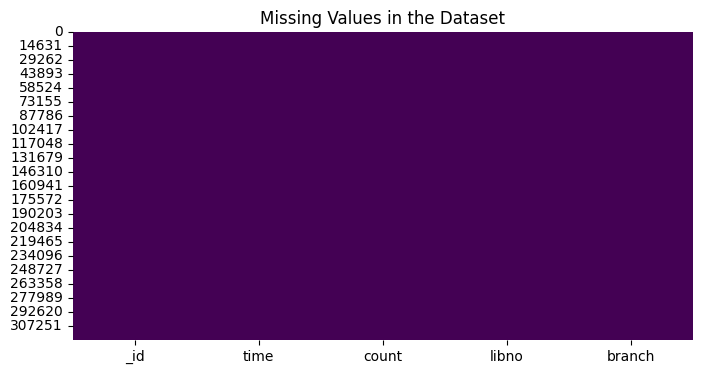

,0
_id,0
time,0
count,0
libno,0
branch,0


In [ ]:
# Visualizing missing data with a heatmap to easily identify columns with missing values
plt.figure(figsize=(8, 4))
sns.heatmap(data_visitor.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values in the Dataset')
plt.show()

missing_values = data_visitor.isnull().sum()
missing_values

## OBS bør køres inden resten af koden 1/2
(Efter imports)

In [ ]:
# split the datetime column
# assert datetime format
data_visitor['time'] = pd.to_datetime(data_visitor['time'])

# create copy of dataset for comparrison with transaction data
data_visitors_2016 = data_visitor.copy()

# Split the 'time' column into separate columns
data_visitor['year'] = data_visitor['time'].dt.year
data_visitor['month'] = data_visitor['time'].dt.month
data_visitor['weekday'] = data_visitor['time'].dt.day_of_week
data_visitor['day'] = data_visitor['time'].dt.day
data_visitor['hour'] = data_visitor['time'].dt.hour

#2. Describe

# display all visitor data
data_visitor

,_id,time,count,libno,branch,year,month,weekday,day,hour
0,1,2015-08-01 00:00:00,2,775100,Hovedbiblioteket,2015,8,5,1,0
1,2,2015-08-01 01:00:00,1,775100,Hovedbiblioteket,2015,8,5,1,1
2,3,2015-08-01 02:00:00,2,775100,Hovedbiblioteket,2015,8,5,1,2
3,4,2015-08-01 04:00:00,1,775100,Hovedbiblioteket,2015,8,5,1,4
4,5,2015-08-01 06:00:00,1,775100,Hovedbiblioteket,2015,8,5,1,6
...,...,...,...,...,...,...,...,...,...,...
321864,289818,2019-06-30 20:00:00,8,775147,Hasle Bibliotek,2019,6,6,30,20
321865,289819,2019-06-30 21:00:00,5,775147,Hasle Bibliotek,2019,6,6,30,21
321866,289822,2019-06-30 23:00:00,3,775147,Hasle Bibliotek,2019,6,6,30,23
321867,289823,2019-06-30 22:00:00,4,775147,Hasle Bibliotek,2019,6,6,30,22


## OBS bør køres inden resten af koden 2/2

In [ ]:
# tilpas et subset af datasættet til transaction datasættet
start_date =  pd.to_datetime('2016-06-28 11')
end_date =  pd.to_datetime('2016-12-04 21')

data_visitors_2016 = data_visitors_2016[(data_visitors_2016['time'] >= start_date) & (data_visitors_2016['time'] <= end_date)]

# display visits in specified year
data_visitors_2016

,_id,time,count,libno,branch,year,month,weekday,day,hour
5872,5873,2016-06-28 11:00:00,389,775100,Hovedbiblioteket,2016,6,1,28,11
5873,5874,2016-06-28 12:00:00,437,775100,Hovedbiblioteket,2016,6,1,28,12
5874,5875,2016-06-28 13:00:00,446,775100,Hovedbiblioteket,2016,6,1,28,13
5875,5876,2016-06-28 14:00:00,397,775100,Hovedbiblioteket,2016,6,1,28,14
5876,5877,2016-06-28 15:00:00,427,775100,Hovedbiblioteket,2016,6,1,28,15
...,...,...,...,...,...,...,...,...,...,...
127426,95361,2016-12-04 21:00:00,5,775120,Højbjerg Bibliotek,2016,12,6,4,21
127427,95362,2016-12-04 19:00:00,5,775120,Højbjerg Bibliotek,2016,12,6,4,19
127428,95363,2016-12-04 16:00:00,8,775120,Højbjerg Bibliotek,2016,12,6,4,16
127429,95364,2016-12-04 14:00:00,18,775120,Højbjerg Bibliotek,2016,12,6,4,14


## Initial preparation

In [ ]:
# display info about the 2016-specified total visitors dataset
data_visitors_2016.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30765 entries, 5872 to 127430
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   _id     30765 non-null  int64         
 1   time    30765 non-null  datetime64[ns]
 2   count   30765 non-null  int64         
 3   libno   30765 non-null  int64         
 4   branch  30765 non-null  object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 1.4+ MB


In [ ]:
# sum up all duplicates and null values
duplicates = data_visitor.duplicated().sum()
duplicate_ids = data_visitor.duplicated('_id').sum()

duplicates, duplicate_ids # supposedly 32066 duplikerede rows, svarende til dokk1 visitor datasættet

(0, 32066)

In [ ]:
duplicate_ids_lib = data_visitor.duplicated(subset=['_id', 'branch']).sum()
duplicate_ids_lib # indikerer, at det er de forskellige filialer, som af den ene eller anden grund, har registreret transaktioner med samme ID som hos et andet filial

0

In [ ]:
# display specified row counts for both visitor datasets
# det er nok alligevel fordi vi sætter dokk1 dataene ind
data_vis_dok.count(), data_vis_oth[data_vis_oth['libno'] == 775100].count() # mystery solved alle duplicates er fra data_vis_dok dataframet

(_id      32066
 time     32066
 count    32066
 libno    32066
 dtype: int64,
 _id      4816
 libno    4816
 time     4816
 count    4816
 dtype: int64)

In [ ]:
# description table for the total visitors dataset
data_visitor.describe()

,_id,time,count,libno,year,month,weekday,day,hour
count,321869.000000,321869,321869.000000,321869.000000,321869.000000,321869.000000,321869.000000,321869.000000,321869.000000
mean,132063.556987,2016-07-30 01:49:42.001994496,34.327773,775140.395400,2016.099121,6.260926,2.761142,15.547894,13.245277
min,1.000000,2014-01-02 03:00:00,0.000000,775100.000000,2014.000000,1.000000,0.000000,1.000000,0.000000
25%,48402.000000,2015-04-26 08:00:00,4.000000,775126.000000,2015.000000,3.000000,1.000000,8.000000,10.000000
50%,128869.000000,2016-07-06 18:00:00,10.000000,775144.000000,2016.000000,6.000000,3.000000,15.000000,13.000000
75%,209336.000000,2017-11-03 07:00:00,28.000000,775160.000000,2017.000000,9.000000,4.000000,23.000000,17.000000
max,289824.000000,2019-06-30 23:00:00,32439.000000,775170.000000,2019.000000,12.000000,6.000000,31.000000,23.000000
std,88316.300008,NaN,149.203465,21.512724,1.502707,3.418832,1.934844,8.740536,4.579223


In [ ]:
# information table for the total visitors dataset
data_visitor.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 321869 entries, 0 to 321868
Data columns (total 10 columns):
 #   Column   Non-Null Count   Dtype         
---  ------   --------------   -----         
 0   _id      321869 non-null  int64         
 1   time     321869 non-null  datetime64[ns]
 2   count    321869 non-null  int64         
 3   libno    321869 non-null  int64         
 4   branch   321869 non-null  object        
 5   year     321869 non-null  int32         
 6   month    321869 non-null  int32         
 7   weekday  321869 non-null  int32         
 8   day      321869 non-null  int32         
 9   hour     321869 non-null  int32         
dtypes: datetime64[ns](1), int32(5), int64(3), object(1)
memory usage: 18.4+ MB


In [ ]:
data_trans['date'] = pd.to_datetime(data_trans['date'])

# Extract hour from date for grouping by hourly intervals
data_trans['hour'] = data_trans['date'].dt.floor('h')

# Group by branch, hour, and type to calculate the sum of counts
hourly_totals = data_trans.groupby(['location', 'hour', 'type']).size().unstack(fill_value=0)

hourly_totals = hourly_totals.sort_index(level=['hour', 'location'])
# Display the formatted dataset

hourly_2 = hourly_totals.reset_index()

# Rename columns for clarity
hourly_2.columns = ['location', 'hour', 'loans', 'returns']

hourly_2.head()

,location,hour,loans,returns
0,775100,2016-06-28 11:00:00,130,120
1,775120,2016-06-28 11:00:00,10,10
2,775122,2016-06-28 11:00:00,10,0
3,775126,2016-06-28 11:00:00,20,10
4,775127,2016-06-28 11:00:00,0,20


In [ ]:
hourly_2['hour'] = pd.to_datetime(hourly_2['hour'])
data_visitors_2016['time'] = pd.to_datetime(data_visitors_2016['time'])

# Merge the two dataframes on 'location' and 'time' (visitor_df's 'libno' maps to loans_returns_df's 'location')
merged_df = pd.merge(
    hourly_2,
    data_visitors_2016[['time', 'count', 'libno', 'branch']],
    left_on=['hour', 'location'],
    right_on=['time', 'libno'],
    how='inner'  # Use 'inner' to get only matching records
)

# Drop the redundant columns from the merged dataframe (if necessary)
merged_df = merged_df.drop(columns=['libno', 'time'])

# Optionally, you can now rename the columns for better clarity
merged_df = merged_df.rename(columns={
    'count': 'visitor_count',
    'branch': 'library_branch'
})

## Merged visitor-transaction dataset

In [ ]:
merged_df.head()

,location,hour,loans,returns,visitor_count,library_branch
0,775100,2016-06-28 11:00:00,130,120,389,Hovedbiblioteket
1,775120,2016-06-28 11:00:00,10,10,20,Højbjerg Bibliotek
2,775122,2016-06-28 11:00:00,10,0,9,Beder-Malling Bibliotek
3,775126,2016-06-28 11:00:00,20,10,7,Solbjerg Bibliotek
4,775127,2016-06-28 11:00:00,0,20,14,Tranbjerg Bibliotek



## Library usage trennds

In [ ]:
#3. (Exploratory) data analysis

# Besøgstal for alle biblioteker
total_visitors_per_library = data_visitor.groupby('branch')['count'].sum().sort_values(ascending=False)

# Percentence of vistitors by Year/Month/Day/Hour
percentage_visitors_per_year_split = (data_visitor.groupby('year')['count'].sum() / data_visitor['count'].sum() * 100).sort_values(ascending=False)
percentage_visitors_per_month_split = (data_visitor.groupby('month')['count'].sum() / data_visitor['count'].sum() * 100).sort_values(ascending=False)
percentage_visitors_per_dow_split = (data_visitor.groupby('weekday')['count'].sum() / data_visitor['count'].sum() * 100).sort_values(ascending=False)
percentage_visitors_per_day_split = (data_visitor.groupby('day')['count'].sum() / data_visitor['count'].sum() * 100).sort_values(ascending=False)
percentage_visitors_per_hour_split = (data_visitor.groupby('hour')['count'].sum() / data_visitor['count'].sum() * 100).sort_values(ascending=False)

# display total visitors per branch
total_visitors_per_library

,count
branch,
Hovedbiblioteket,5740453
Risskov Bibliotek,1035721
Viby Bibliotek,803514
Åby Bibliotek,636221
Hasle Bibliotek,419393
Højbjerg Bibliotek,396078
Gellerup Bibliotek,373669
Lystrup Bibliotek,358133
Harlev Bibliotek,337551


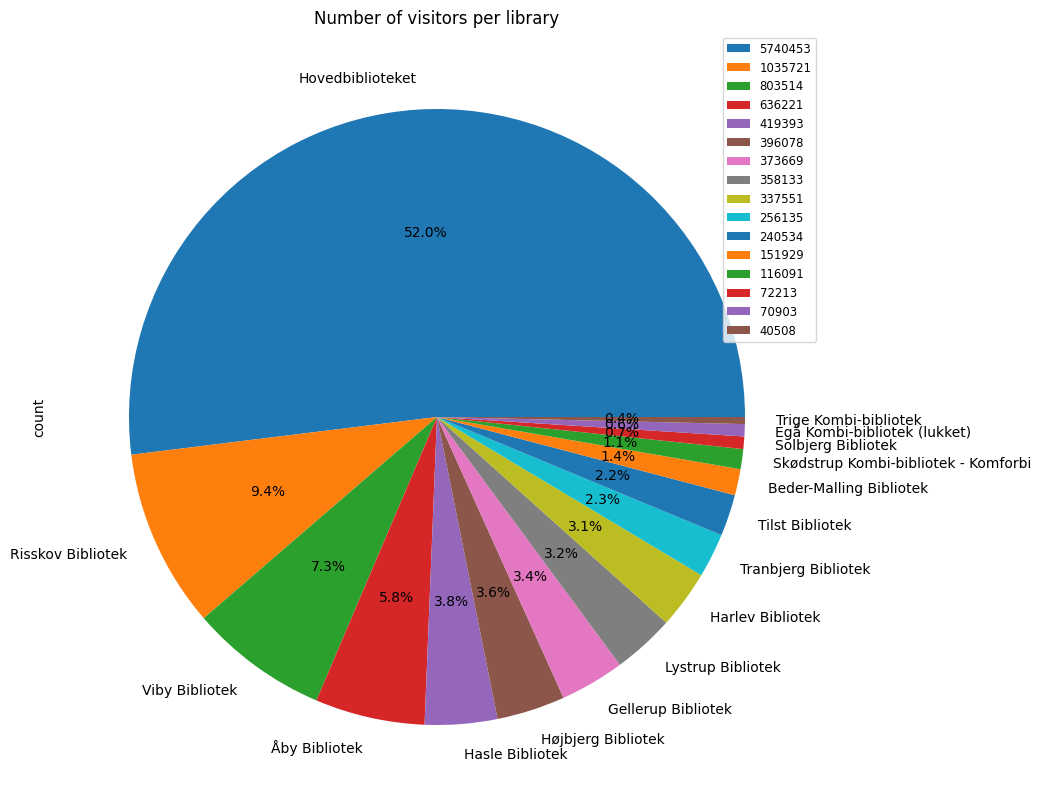

In [ ]:
# display total visitors as figure
plt.figure(figsize=[10,10])
total_visitors_per_library.plot(kind='pie', autopct='%1.1f%%')
plt.title('Number of visitors per library')
plt.legend(total_visitors_per_library, fontsize='small', loc='upper right')
plt.show()

### pie chart explainer
Fordeling af alle besøgende for hvort bibliotek i Aarhus kommune. Over halvdelen af de besøgende er registreret på hovedbiblioteket/Dokk1.

Hvis dataene ellers var tilgængelige ville vi kunne se fordelingen på et geografisk kort - lige nu kan vi dog kun gætte på at besøgstallene er mindre jo længere væk vi kommer fra Aarhus midtby.

In [ ]:
# display total visitors per year/month/day/hour percentages
percentage_visitors_per_year_split, percentage_visitors_per_month_split, percentage_visitors_per_dow_split, percentage_visitors_per_day_split, percentage_visitors_per_hour_split

(year
 2017    22.423112
 2016    20.407418
 2018    19.343525
 2015    16.315110
 2014    13.091302
 2019     8.419532
 Name: count, dtype: float64,
 month
 3     9.573161
 2     9.186847
 5     8.906787
 1     8.798262
 8     8.628410
 10    8.504264
 9     8.489312
 6     8.409658
 4     8.337598
 11    8.190028
 7     6.561671
 12    6.414002
 Name: count, dtype: float64,
 weekday
 1    17.997472
 0    17.508498
 3    16.982127
 2    16.318332
 4    14.335573
 5    10.472370
 6     6.385628
 Name: count, dtype: float64,
 day
 28    4.056314
 21    3.528314
 4     3.493487
 6     3.458986
 11    3.458109
 3     3.441021
 14    3.435509
 27    3.368010
 7     3.364553
 8     3.349692
 12    3.329328
 13    3.328351
 15    3.328133
 10    3.302765
 2     3.290709
 20    3.269567
 18    3.241891
 16    3.222414
 17    3.206630
 9     3.200014
 5     3.179198
 23    3.176980
 29    3.155865
 22    3.138823
 19    3.122052
 26    3.027945
 30    3.019546
 24    2.973252
 1     2.955495
 

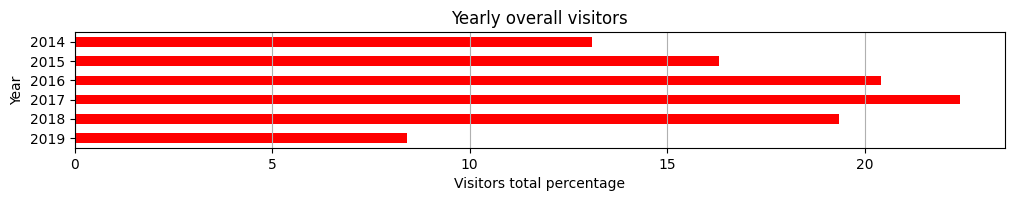

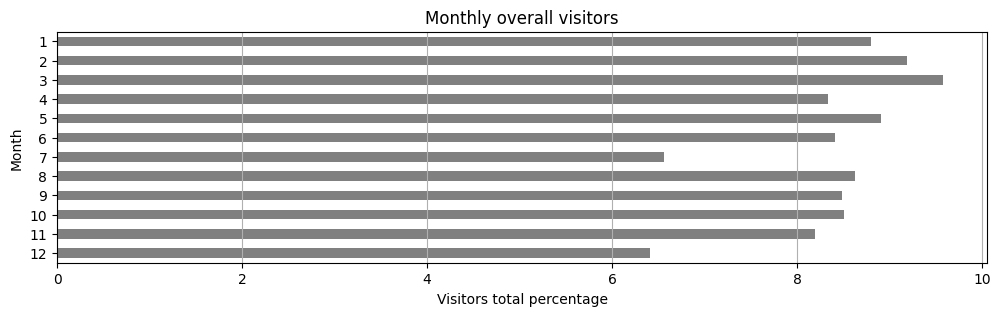

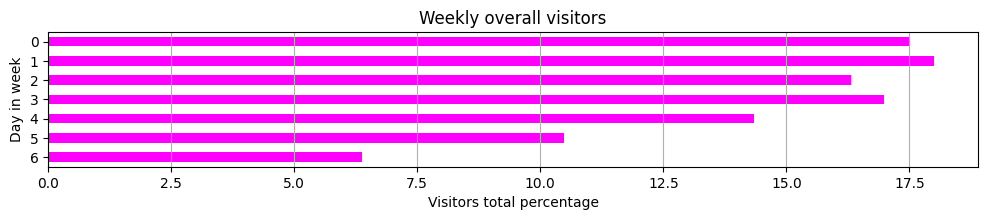

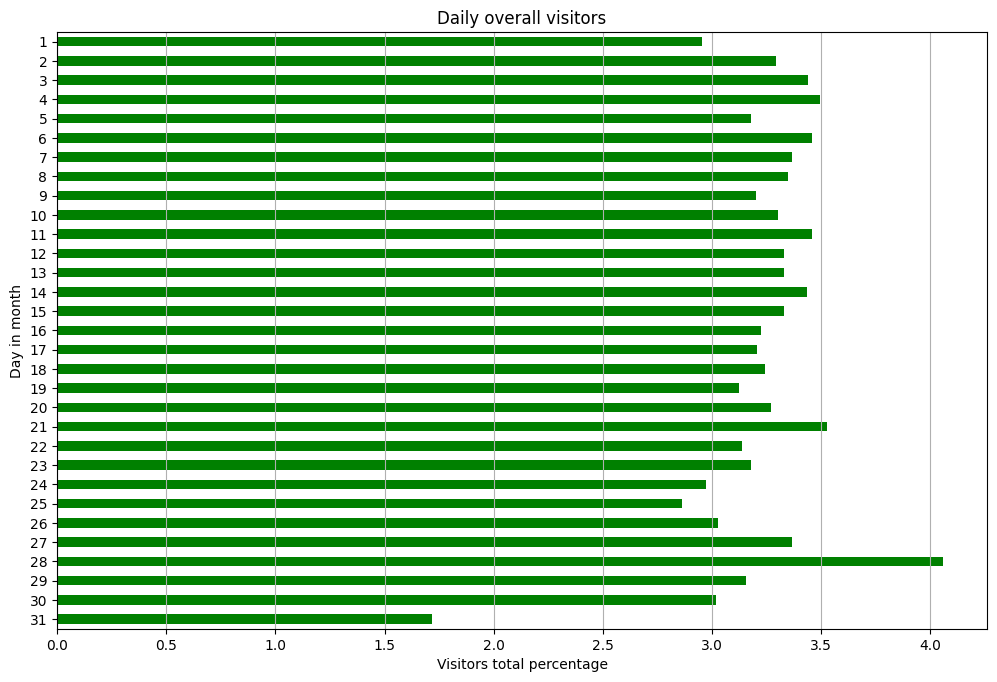

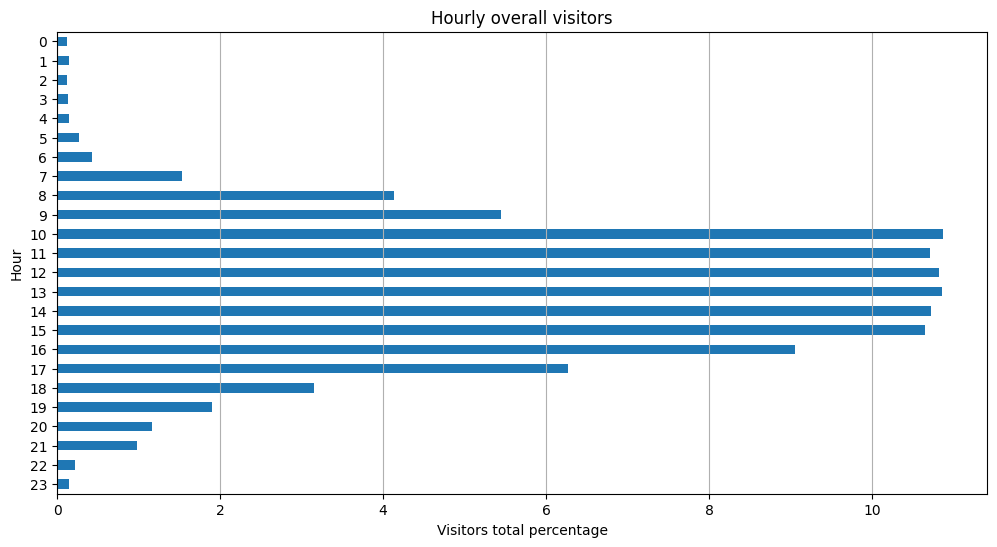

In [ ]:
# display yearly, monthly, daily, hourly visitors
# nb tager ikke højde for gennemsnit i the year of the lord 2016, men er derimod et helt overordnet gennemsnit

# Yearly Visitors - not as much needed as we mostly focus on year 2016
plt.figure(figsize=(12, len(percentage_visitors_per_year_split)/4))

percentage_visitors_per_year_split.sort_index().plot(kind='barh', color='red')

plt.title('Yearly overall visitors')
plt.xlabel('Visitors total percentage')
plt.ylabel('Year')

plt.gca().invert_yaxis()
plt.grid(visible=True, axis='x')

plt.show()

# Monthly visitors
plt.figure(figsize=(12, len(percentage_visitors_per_month_split)/4))

percentage_visitors_per_month_split.sort_index().plot(kind='barh', color='grey')

plt.title('Monthly overall visitors')
plt.xlabel('Visitors total percentage')
plt.ylabel('Month')

plt.gca().invert_yaxis()
plt.grid(visible=True, axis='x')
plt.show()

# Weekday visitors
plt.figure(figsize=(12, len(percentage_visitors_per_dow_split)/4))

percentage_visitors_per_dow_split.sort_index().plot(kind='barh', color='magenta')

plt.title('Weekly overall visitors')
plt.xlabel('Visitors total percentage')
plt.ylabel('Day in week')

plt.gca().invert_yaxis()
plt.grid(visible=True, axis='x')

plt.show()

# Could also implement an actual weekly visitors, which would maybe show an increase or decrease in visitors in week 42 (efterårsferie) and so on

# Daily visitors
plt.figure(figsize=(12, len(percentage_visitors_per_day_split)/4))

percentage_visitors_per_day_split.sort_index().plot(kind='barh', color='green')

plt.title('Daily overall visitors')
plt.xlabel('Visitors total percentage')
plt.ylabel('Day in month')

plt.gca().invert_yaxis()
plt.grid(visible=True, axis='x')

plt.show()

# hourly visitors
plt.figure(figsize=(12, len(percentage_visitors_per_hour_split)/4))

percentage_visitors_per_hour_split.sort_index().plot(kind='barh')

plt.title('Hourly overall visitors')
plt.xlabel('Visitors total percentage')
plt.ylabel('Hour')

plt.gca().invert_yaxis()
plt.grid(visible=True, axis='x')

plt.show()

### bargraf explainer
- År, på årsbasis ser vi et stigende antal besøgende
 - datasættet er optaget i perioden 1.1.2014-30.6.2019, jf. opendata, derfor vises kun halv statistik for 2019
- Måned, på månedsbasis er der generelt flere besøgende i foråret, fremfor efteråret, samt et større dyk i besøgstallene i feriemånederne - juli og december
- Dag, på daglig basis er der ikke en konsistent udvikling i besøgstal (veksler meget omkring samme antal fra dag til dag), der er dog lidt flere besøgende i starten af måneden fremfor slutningen af måneden
 - vær også opmærksom på at dag 31 er halveret, fordi denne kun findes i halvt omfang af øvrige datoer
 - stigningen på dag 28 kan være tegn på udløbsdatoer for lån - altså at mange afleverer bøger denne dag (sådan fungerer låneperioder dog umiddelbart ikke) - eller p+å en måde være relateret til februar måned, der slutter den 28.
- Time, på timebasis er der en normal distribution henover dagstimerne, hvor der registreres færre besøgende (OBS besøgende er ikke nødvendigvis inde på biblioteket) i de tidlige og sene timer, mens der er flest i åbningstiden og færre tidlig formiddag+sen eftermiddag/aften (jf. selvbetjening)

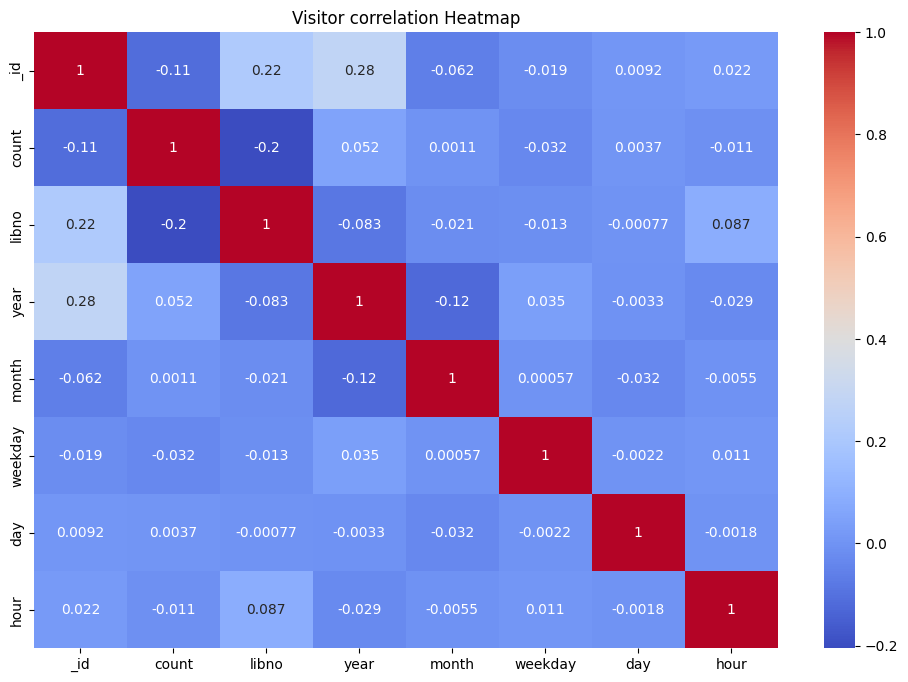

In [ ]:
# Correlation Analysis
import seaborn as sns
import matplotlib.pyplot as plt

# Correlation matrix
correlation_matrix = data_visitor.corr(numeric_only=True) # no point in checking corr for the data_visitors_2016 df yet

# Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Visitor correlation Heatmap')
plt.show()


### heatmap explainer
Ud fra heatmappet kan vi se, at der umiddelbart kun er tale om en positiv sammenhæng mellem et givent bibliotek og besøg pr time, hvor der i stedet generelt er tale om negativ (hvis nogen) mellem biblioteksnummer og årlige, månedlige og daglige besøgstal
- det indikerer umiddelbart at der kun er en sammenhæng at finde i hvilke dagstimer, bibliotekerne besøges, men at der på år/måned/dag ikke er nogen sammenhæng
 - understøttes yderligere af forrige horisontale bargraf, om end disse også viser en stigning af besøgtal pr år

Kolonnen _id bør ikke medregnes, da denne selvfølgelig vil stige i takt med dataindsamlingen - og dermed årstallet
- det kan dog være interessant at kigge på sammenhængen mellem libno og _id

Kolonnen count og libno indikerer at der er en negativ sammenhæng mellem antal besøgende og et givent bibliotek
- kan være tegn på, at der er en tendens til færre besøgende pr bibliotek - hvilket strider imod bargraferne, men det kan måske være tegn på at de besøgende migrerer til andre biblioteker (såsom hovedbiblioteket)

Kolonnen year og month viser også en lille negativ sammenhæng, hvilket måske kan være tegn på, at der er færre besøgende i en given måned som årene skrider frem

## Library usage trends in fall 2016

In [ ]:
# prepare data for analysis of visitors in 2016

data_vis2016_bmon_split = data_visitors_2016.groupby(['branch', 'month'])['year'].sum().unstack().sort_values(by=6, ascending=False) # fordeling af besøgende i en måned per dag
data_vis2016_wday_split = data_visitors_2016.groupby(['branch', 'weekday'])['day'].sum().unstack().sort_values(by=0, ascending=False) # fordeling af besøgende i en uge per dag
data_vis2016_bday_split = data_visitors_2016.groupby(['branch', 'day'])['month'].sum().unstack().sort_values(by=1, ascending=False) # fordeling af besøgende i en måned per dag
data_vis2016_bhou_split = data_visitors_2016.groupby(['branch', 'hour'])['day'].sum().unstack().sort_values(by=12, ascending=False) # fordeling af besøgende i en måned per dag

In [ ]:
data_visitors_2016['count'].sum(), data_visitors_2016['count'].describe()

(1004922,
 count    30765.000000
 mean        32.664456
 std         81.131297
 min          0.000000
 25%          3.000000
 50%         10.000000
 75%         26.000000
 max       2682.000000
 Name: count, dtype: float64)

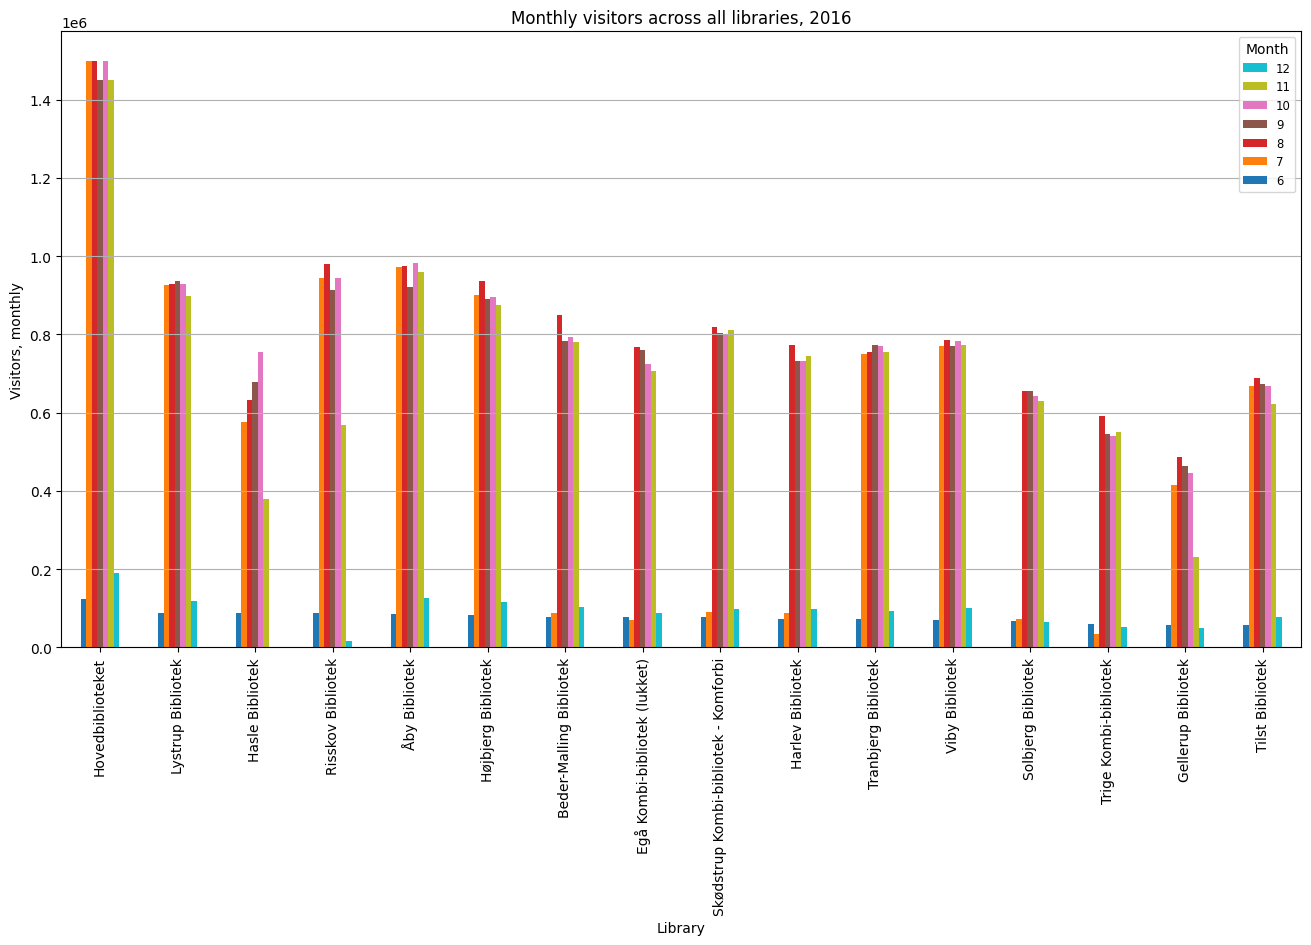

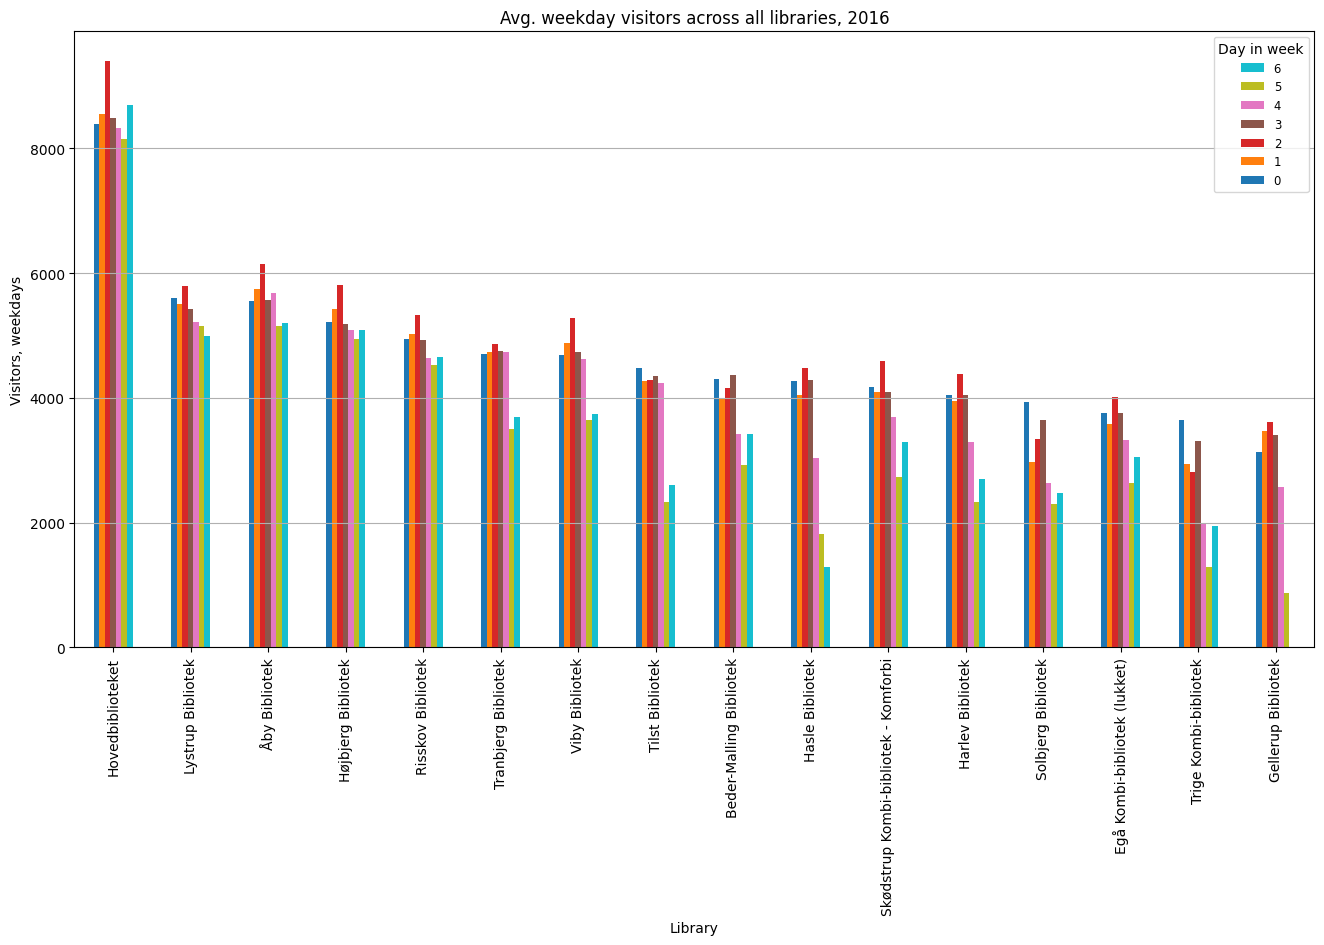

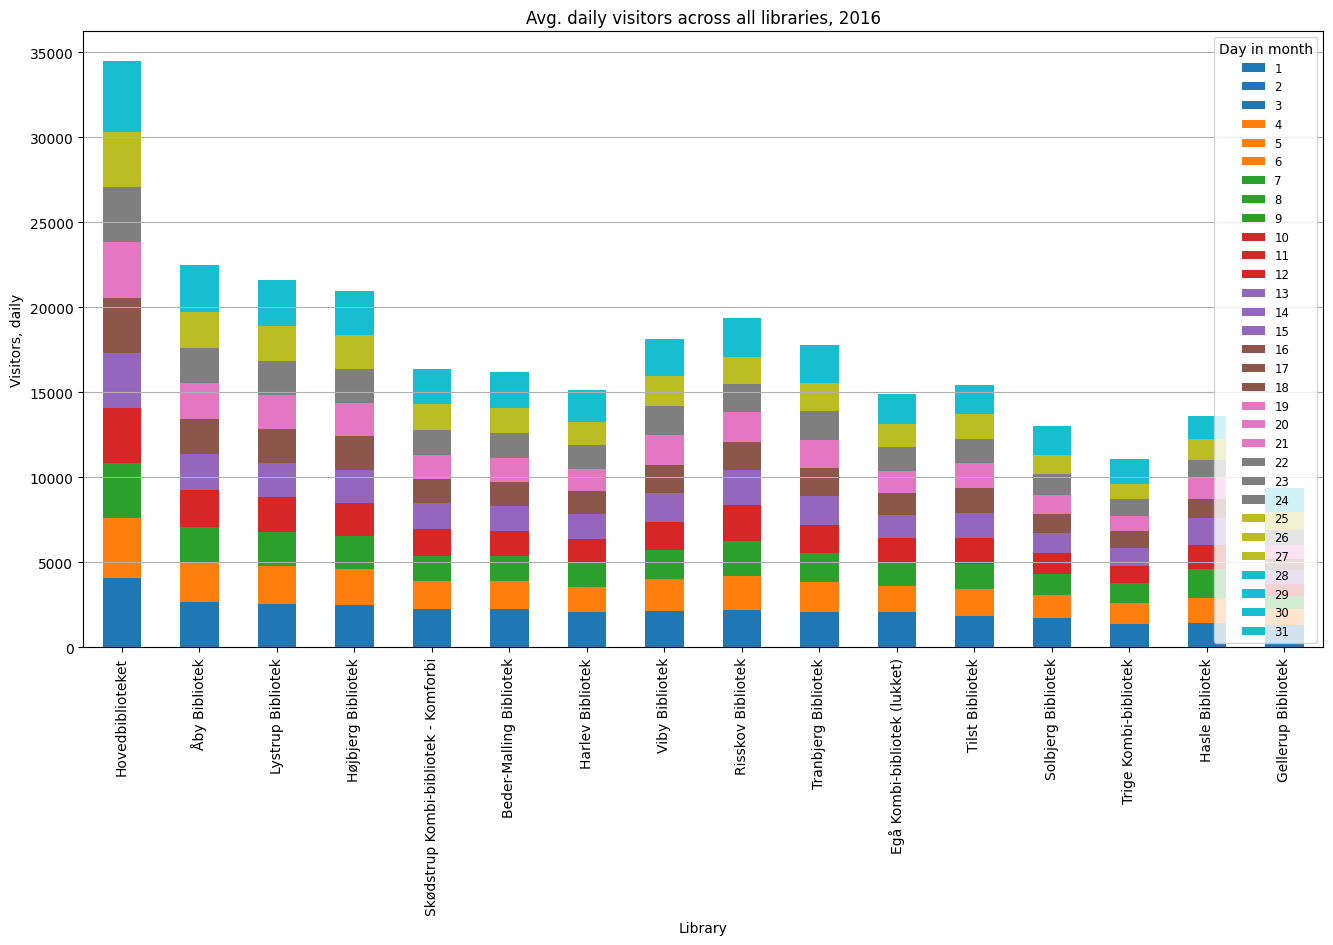

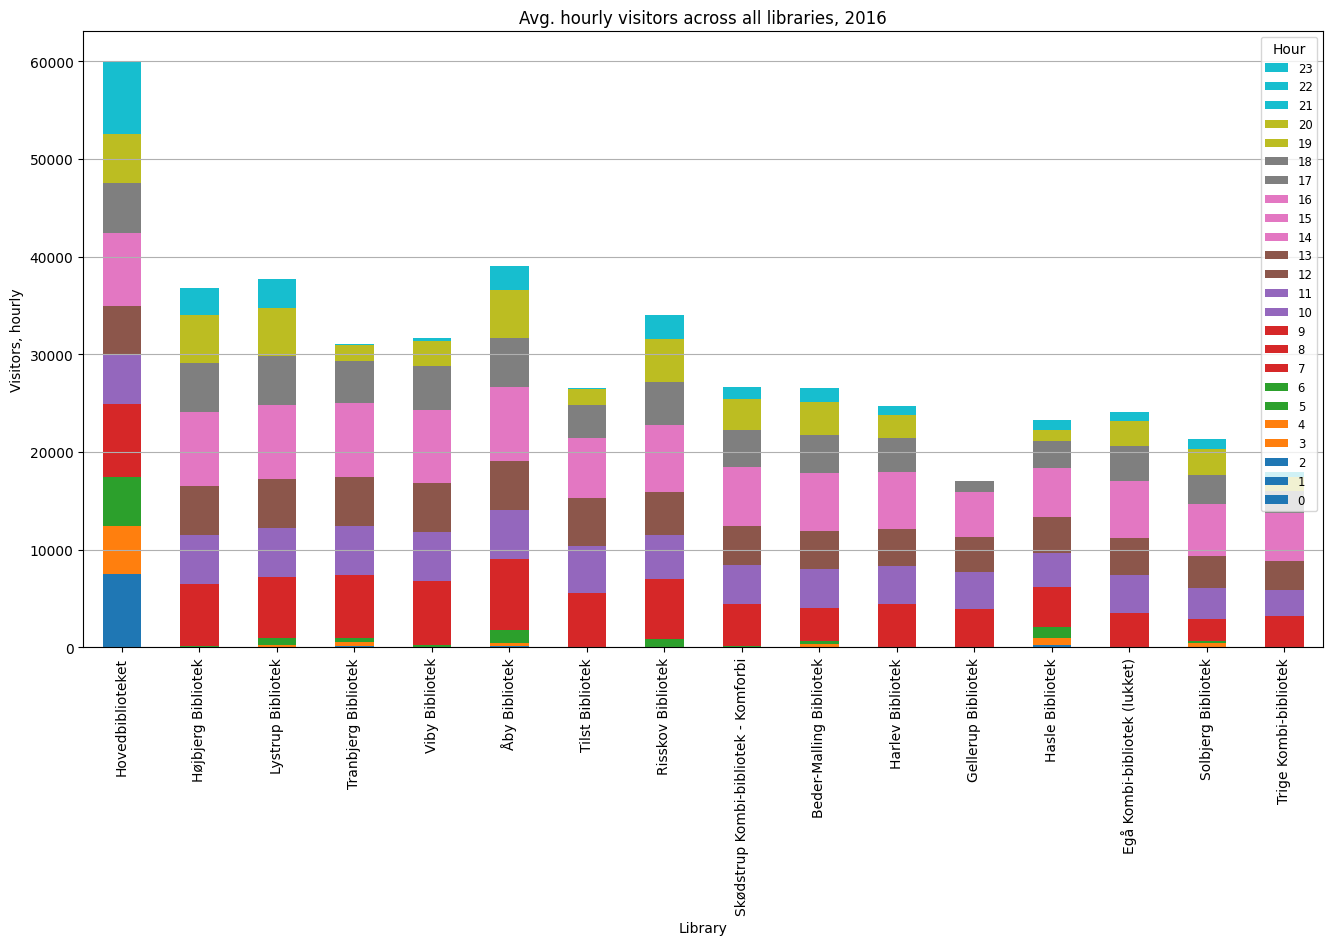

In [ ]:
# Månedlig, daglig, timevise besøgstal pr bibliotek i 2016, jf. transaction datasættet, der udelukkende er for transaktioner i 2016

# total visitors per branch per month, 2016
data_vis2016_bmon_split.plot(kind='bar', figsize=(16, 8), cmap='tab10') # , stacked=True
plt.title('Monthly visitors across all libraries, 2016')
plt.xlabel('Library')
plt.ylabel('Visitors, monthly')
plt.legend(title='Month', reverse=True, fontsize='small')
plt.xticks(rotation=90)
plt.grid(True, axis='y')
plt.show()

# total visitors per branch per weekday, 2016
data_vis2016_wday_split.plot(kind='bar', figsize=(16, 8), cmap='tab10')
plt.title('Avg. weekday visitors across all libraries, 2016')
plt.xlabel('Library')
plt.ylabel('Visitors, weekdays')
plt.legend(title='Day in week', reverse=True, fontsize='small')
plt.xticks(rotation=90)
plt.grid(True, axis='y')
plt.show()

# total visitors per branch per day, 2016
data_vis2016_bday_split.plot(kind='bar', stacked=True, figsize=(16, 8), cmap='tab10')
plt.title('Avg. daily visitors across all libraries, 2016')
plt.xlabel('Library')
plt.ylabel('Visitors, daily')
plt.legend(title='Day in month', fontsize='small')
plt.xticks(rotation=90)
plt.grid(True, axis='y')
plt.show()

# total visitors per branch per hour, 2016
data_vis2016_bhou_split.plot(kind='bar', stacked=True, figsize=(16, 8), cmap='tab10')
plt.title('Avg. hourly visitors across all libraries, 2016')
plt.xlabel('Library')
plt.ylabel('Visitors, hourly')
plt.legend(title='Hour', reverse=True, fontsize='small')
plt.xticks(rotation=90)
plt.grid(True, axis='y')
plt.show()


### 2016 bargraf explainer
Den månedlige graf er sorteret efter juli måned, faldende, da vi kan se at det i forvejen er den måned med færrest besøgende
- Vi kan derudover også antage, at der måske er ferielukket på de mindre biblioteker - hvilket også kan være tilfældet i december måned

Den daglige graf viser ikke umiddelbart mere end hvad vi ved, vi kan dog se at fordelingen af besøgende pr bibliotek ikke afhænger af dagene
- Den daglige graf er sorteret efter første dag i måneden, for consistency

Den timevise graf viser os nogenlunde hvornår bibliotekerne er åbne, i det antallet af besøgende er større omkring typiske åbningstider
- vi kan også antage hvilke biblioteker der har og ikke har selvbetjening, ud fra om der er få besøgende eller slet ingen, jf. fx gellerup bibliotek
- Dan timevise graf er sorteret efter kl 12, for consistency

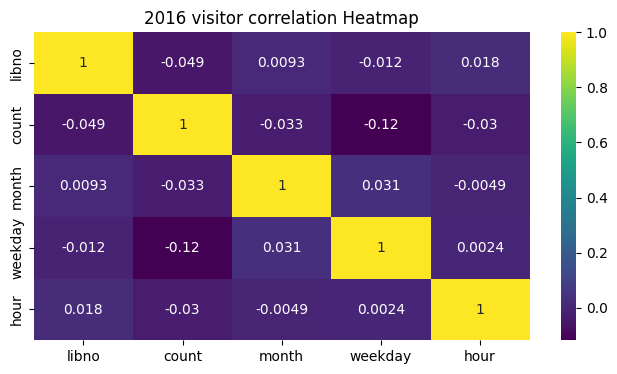

In [ ]:
# ud fra bargraferne vil det være interessant at se på om der er en correlation mellem fx måneder og besøgstal, samt timer og besøgstal

# Correlation Analysis
import seaborn as sns
import matplotlib.pyplot as plt

# Correlation matrix
corr_2016 = data_visitors_2016[['libno', 'count', 'month', 'weekday', 'hour']]
# hovedbiblioteket er en outlier mht. åbningstider og sorteres derfor fra
corr = corr_2016[corr_2016['libno'] != 775100].corr()

# Heatmap
plt.figure(figsize=(8, 4))
sns.heatmap(corr, annot=True, cmap='viridis')
plt.title('2016 visitor correlation Heatmap')
plt.show()

### 2016 heatmap explainer
Generelt ikke mange sammenhænge mellem besøgstider og bibliotekerne, det er overvejende det samme som før

Vi ser at det totale antal besøgende påvirkes negativt af biblioteksnummeret og at måned og timer også påvirker besøgstallet negativt - hvilket kan indikere at besøgstallene afhænger af biblioteket og måneder/timer på året/dagen
- det kan man selvfølgelig også relativt nemt tænke sig til og det er derudover også vigtigt at have i mente at det er korrelation og ikke kausation

Derimod viser heatmappet også at biblioteksnummeret er påvirket af måneder og timer - hvilket umiddelbart indikerer at der er tale om sted-specifikke åbningstider/ferie

## Visitor og transaction patterns

Combining Visitor and Transaction Data:

Join Data: Merge the visitor statistics and transaction data using a shared library identifier or date fields.

Visitor-Transaction Ratios: Calculate ratios (e.g., transactions per visitor) by library and time period to identify engagement differences.

In [ ]:
# Join data
# already done: merged visitor-transaction dataset header
merged_df.describe()

,location,hour,loans,returns,visitor_count
count,22819.000000,22819,22819.000000,22819.000000,22819.000000
mean,775140.720759,2016-09-18 02:19:10.251983104,33.755204,33.350278,42.061659
min,775100.000000,2016-06-28 11:00:00,0.000000,0.000000,0.000000
25%,775126.000000,2016-08-12 15:00:00,10.000000,10.000000,6.000000
50%,775140.000000,2016-09-18 13:00:00,20.000000,20.000000,15.000000
75%,775160.000000,2016-10-25 17:00:00,40.000000,40.000000,34.000000
max,775170.000000,2016-12-04 21:00:00,420.000000,340.000000,1311.000000
std,20.791915,NaN,42.145084,37.829727,90.430837


In [ ]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22819 entries, 0 to 22818
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   location        22819 non-null  int64         
 1   hour            22819 non-null  datetime64[ns]
 2   loans           22819 non-null  int64         
 3   returns         22819 non-null  int64         
 4   visitor_count   22819 non-null  int64         
 5   library_branch  22819 non-null  object        
dtypes: datetime64[ns](1), int64(4), object(1)
memory usage: 1.0+ MB


In [ ]:
merged_df.tail(10)

,location,hour,loans,returns,visitor_count,library_branch
22809,775122,2016-12-04 18:00:00,20,10,8,Beder-Malling Bibliotek
22810,775140,2016-12-04 18:00:00,10,0,4,Åby Bibliotek
22811,775167,2016-12-04 18:00:00,20,10,13,Lystrup Bibliotek
22812,775168,2016-12-04 18:00:00,0,20,5,Skødstrup Kombi-bibliotek - Komforbi
22813,775120,2016-12-04 19:00:00,0,10,5,Højbjerg Bibliotek
22814,775167,2016-12-04 19:00:00,40,20,8,Lystrup Bibliotek
22815,775120,2016-12-04 20:00:00,10,0,3,Højbjerg Bibliotek
22816,775122,2016-12-04 20:00:00,10,30,1,Beder-Malling Bibliotek
22817,775140,2016-12-04 20:00:00,10,0,2,Åby Bibliotek
22818,775122,2016-12-04 21:00:00,10,20,4,Beder-Malling Bibliotek


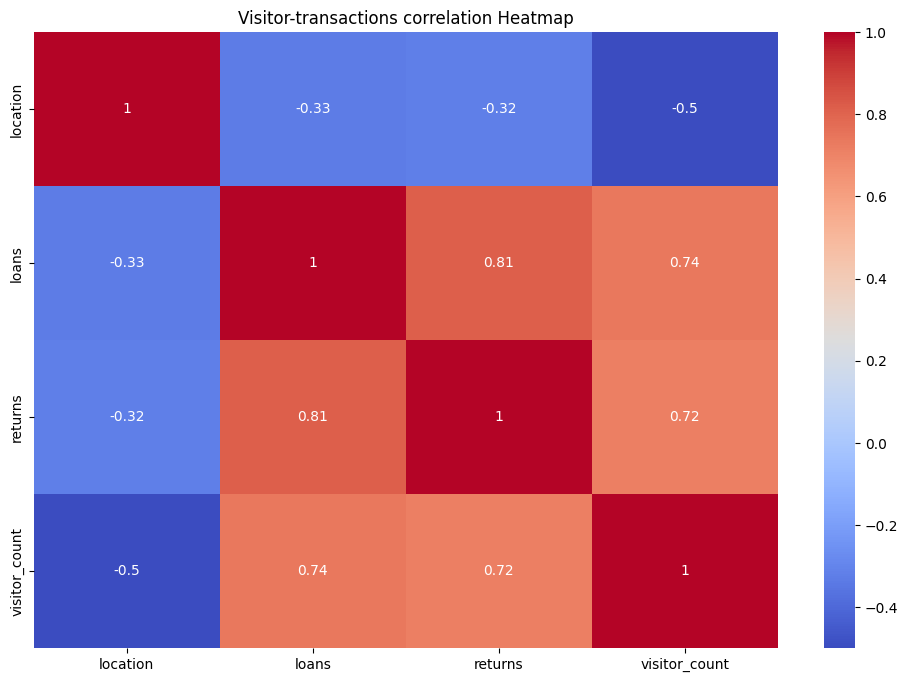

In [ ]:
# Visitor-transaction ratios

# Correlation Analysis
# Correlation matrix
merged_corr_matrix = merged_df.corr(numeric_only=True)

# Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(merged_corr_matrix, annot=True, cmap='coolwarm')
plt.title('Visitor-transactions correlation Heatmap')
plt.show()


# Data preparation
Forberedelse af datasættet til model training
1. Select
2. Clean
3. Construct
4. Integrate
5. Format

In [ ]:
# vi vil bruge alle visitor data, men først og fremmest lave en kopi vi kan tilpasse ML
# dataene vi har tilgængelig er disse:
data_visitor.head()

,_id,time,count,libno,branch,year,month,weekday,day,hour
0,1,2015-08-01 00:00:00,2,775100,Hovedbiblioteket,2015,8,5,1,0
1,2,2015-08-01 01:00:00,1,775100,Hovedbiblioteket,2015,8,5,1,1
2,3,2015-08-01 02:00:00,2,775100,Hovedbiblioteket,2015,8,5,1,2
3,4,2015-08-01 04:00:00,1,775100,Hovedbiblioteket,2015,8,5,1,4
4,5,2015-08-01 06:00:00,1,775100,Hovedbiblioteket,2015,8,5,1,6


In [ ]:
# valg af datasæt
df_visitors_prep = data_visitor.copy() # vi tester model på et datasæt med alle datoer tilgængelige

# clean, construct, integrate
df_visitors_prep['month'] = df_visitors_prep['month'].apply(lambda x: f'0{x}' if x < 10 else str(x))
df_visitors_prep['day'] = df_visitors_prep['day'].apply(lambda x: f'0{x}' if x < 10 else str(x))
df_visitors_prep['hour'] = df_visitors_prep['hour'].apply(lambda x: f'0{x}' if x < 10 else str(x))

# mindsk dimensioner, day kan fjernes, men umiddelbart bedre at beholde year,month,day,hour som en samlet int

#df_visitors_prep['time_as_int'] = df_visitors_prep['year'].astype(str) + df_visitors_prep['month'].astype(str) + df_visitors_prep['day'].astype(str) + df_visitors_prep['hour'].astype(str)
#df_visitors_prep.drop(columns=['time', 'year', 'month', 'day', 'hour'], inplace=True)
#df_visitors_prep['time_as_int'] = df_visitors_prep['time_as_int'].astype(int)

# branch kan også fjernes da den er redundant - det samme kan _id
df_visitors_prep.drop(columns=['_id', 'branch', 'time'], inplace=True)

df_visitors_prep = df_visitors_prep.astype(int)

df_visitors_prep.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 321869 entries, 0 to 321868
Data columns (total 7 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   count    321869 non-null  int64
 1   libno    321869 non-null  int64
 2   year     321869 non-null  int64
 3   month    321869 non-null  int64
 4   weekday  321869 non-null  int64
 5   day      321869 non-null  int64
 6   hour     321869 non-null  int64
dtypes: int64(7)
memory usage: 17.2 MB


In [ ]:
df_visitors_prep.tail()

,count,libno,year,month,weekday,day,hour
321864,8,775147,2019,6,6,30,20
321865,5,775147,2019,6,6,30,21
321866,3,775147,2019,6,6,30,23
321867,4,775147,2019,6,6,30,22
321868,21,775147,2019,6,6,30,19


In [ ]:
data_trans['date'] = pd.to_datetime(data_trans['date'])

# Extract hour from date for grouping by hourly intervals
data_trans['hour'] = data_trans['date'].dt.floor('h')

# Group by branch, hour, and type to calculate the sum of counts
hourly_totals = data_trans.groupby(['location', 'hour', 'type']).size().unstack(fill_value=0)

hourly_totals = hourly_totals.sort_index(level=['location', 'hour'])
# Display the formatted dataset

hourly_2 = hourly_totals.reset_index()

# Rename columns for clarity
hourly_2.columns = ['location', 'hour', 'loans', 'returns']

In [ ]:
hourly_2

,location,hour,loans,returns
0,775100,2016-06-28 11:00:00,130,120
1,775100,2016-06-28 12:00:00,180,180
2,775100,2016-06-28 13:00:00,180,120
3,775100,2016-06-28 14:00:00,170,180
4,775100,2016-06-28 15:00:00,200,220
...,...,...,...,...
25881,775170,2016-12-02 12:00:00,30,40
25882,775170,2016-12-02 15:00:00,10,10
25883,775170,2016-12-03 12:00:00,0,10
25884,775170,2016-12-04 11:00:00,10,30


In [ ]:
hourly_totals # viser opsummeret antal lån/afleveringer pr time pr bibliotek - uden at tage højde for faustnr

type                            1    3
location hour                         
775100   2016-06-28 11:00:00  130  120
         2016-06-28 12:00:00  180  180
         2016-06-28 13:00:00  180  120
         2016-06-28 14:00:00  170  180
         2016-06-28 15:00:00  200  220
...                           ...  ...
775170   2016-12-02 12:00:00   30   40
         2016-12-02 15:00:00   10   10
         2016-12-03 12:00:00    0   10
         2016-12-04 11:00:00   10   30
         2016-12-04 16:00:00   10   20

[25886 rows x 2 columns]

In [ ]:
df_loansreturns = data_trans.copy()

df_loansreturns['year'] = df_loansreturns['hour'].dt.year
df_loansreturns['month'] = df_loansreturns['hour'].dt.month
df_loansreturns['day'] = df_loansreturns['hour'].dt.day
df_loansreturns['hour'] = df_loansreturns['hour'].dt.hour

df_loansreturns['month'] = df_loansreturns['month'].apply(lambda x: f'0{x}' if x < 10 else str(x)).astype(int)
df_loansreturns['day'] = df_loansreturns['day'].apply(lambda x: f'0{x}' if x < 10 else str(x)).astype(int)
df_loansreturns['hour'] = df_loansreturns['hour'].apply(lambda x: f'0{x}' if x < 10 else str(x)).astype(int)

df_loansreturns.drop(columns=['_id', 'date'], inplace=True)

df_loansreturns.tail(10)

,type,location,key,hour,year,month,day
1648980,1,775122,52645956,21,2016,12,4
1648981,1,775122,52595797,21,2016,12,4
1648982,1,775122,50998177,21,2016,12,4
1648983,1,775122,52599997,21,2016,12,4
1648984,1,775122,52429927,21,2016,12,4
1648985,1,775122,52429889,21,2016,12,4
1648986,1,775122,51054598,21,2016,12,4
1648987,1,775122,52595983,21,2016,12,4
1648988,1,775122,52429994,21,2016,12,4
1648989,1,775122,29210446,21,2016,12,4


In [ ]:
df_loansreturns.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1648990 entries, 0 to 1648989
Data columns (total 7 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   type      1648990 non-null  int64 
 1   location  1648990 non-null  int64 
 2   key       1648990 non-null  object
 3   hour      1648990 non-null  int64 
 4   year      1648990 non-null  int32 
 5   month     1648990 non-null  int64 
 6   day       1648990 non-null  int64 
dtypes: int32(1), int64(5), object(1)
memory usage: 81.8+ MB


In [ ]:
# vi vil opsummere antal lån/afleveringer pr faustnummer pr e.g. month

unique_books_pr_month = df_loansreturns.groupby(['location', 'month','day','hour', 'key', 'type']).size().unstack(fill_value=0)

unique_books_pr_month = unique_books_pr_month.sort_index(level=['location', 'month','day','hour', 'key'])
# Display the formatted dataset

unique_books_pr_month

type                              1  3
location month day hour key           
775100   6     28  11   00165492  0  1
                        00753483  1  0
                        05969247  1  0
                        06655718  0  1
                        06750176  1  0
...                              .. ..
775170   12    4   16   52643848  0  1
                        52651670  0  1
                        52656982  0  1
                        52658454  0  1
                        I0127094  0  1

[1562034 rows x 2 columns]

In [ ]:
df_lr_reordered = unique_books_pr_month.reset_index()

df_lr_reordered

type,location,month,day,hour,key,1,3
0,775100,6,28,11,00165492,0,1
1,775100,6,28,11,00753483,1,0
2,775100,6,28,11,05969247,1,0
3,775100,6,28,11,06655718,0,1
4,775100,6,28,11,06750176,1,0
...,...,...,...,...,...,...,...
1562029,775170,12,4,16,52643848,0,1
1562030,775170,12,4,16,52651670,0,1
1562031,775170,12,4,16,52656982,0,1
1562032,775170,12,4,16,52658454,0,1


In [ ]:
df_lr_reordered.columns = ['library', 'month', 'day', 'hour', 'faustkey', 'loans', 'returns']
df_lr_reordered

,library,month,day,hour,faustkey,loans,returns
0,775100,6,28,11,00165492,0,1
1,775100,6,28,11,00753483,1,0
2,775100,6,28,11,05969247,1,0
3,775100,6,28,11,06655718,0,1
4,775100,6,28,11,06750176,1,0
...,...,...,...,...,...,...,...
1562029,775170,12,4,16,52643848,0,1
1562030,775170,12,4,16,52651670,0,1
1562031,775170,12,4,16,52656982,0,1
1562032,775170,12,4,16,52658454,0,1


In [ ]:
# unique books
unique_faustkeys = df_lr_reordered['faustkey'].unique()

unique_faustkeys.size

154652

In [ ]:
# Tjek hvert unikt faustkey og find forskellen i "month", "day" og "hour"
# "branch" er ikke nødvendig da materialer kan lånes og afleveres forskellige steder
results = []

for faustkey in unique_faustkeys[:150]:
    loan_record = df_lr_reordered[(df_lr_reordered['faustkey'] == faustkey) & (df_lr_reordered['loans'] == 1)]
    return_record = df_lr_reordered[(df_lr_reordered['faustkey'] == faustkey) & (df_lr_reordered['returns'] == 1)]

    if not loan_record.empty and not return_record.empty:
        loan_date = loan_record[['month', 'day', 'hour']].values[0]
        return_date = return_record[['month', 'day', 'hour']].values[0]

        results.append({
            'faustkey': faustkey,
            'loan_month': loan_date[0],
            'loan_day': loan_date[1],
            'loan_hour': loan_date[2],
            'return_month': return_date[0],
            'return_day': return_date[1],
            'return_hour': return_date[2]
        })

# Konverter resultaterne til en DataFrame for nem visning
results_df = pd.DataFrame(results)

results_df


     faustkey  loan_month  loan_day  loan_hour  return_month  return_day  \
0    00753483           6        28         11             7          23   
1    05969247           6        28         11             7          15   
2    06655718          12         1         14             6          28   
3    06750176           6        28         11             7          20   
4    07310463           6        28         11             7          15   
..        ...         ...       ...        ...           ...         ...   
139  29841020           6        28         11             6          28   
140  29901937          10        14          8             6          28   
141  29904928           7         4          9             6          28   
142  29917299           7         4         12             6          28   
143  29934118           6        28         11             7           8   

     return_hour  
0             13  
1             14  
2             11  
3          

# Modelling
Machine learning
1. select modeling techniques
2. generate test design
3. build model
4. access model

## Visitor forecasting
Predict visitor numbers using historical patterns, supporting staff allocation and resource planning.

Select modelling techniques - vi tester her tre modeller
- Linear regression
- Random forrest
- Gradient boosting regressor

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# fjern outliers
Q1 = df_visitors_prep.quantile(0.25)
Q3 = df_visitors_prep.quantile(0.75)
IQR = Q3 - Q1

data_no_outliers = df_visitors_prep[~((df_visitors_prep < (Q1 - 1.5 * IQR)) | (df_visitors_prep > (Q3 + 1.5 * IQR))).any(axis=1)]

# Forbered features og target
X = data_no_outliers[['libno', 'year', 'month', 'weekday', 'day', 'hour']]
y = data_no_outliers['count']

In [ ]:
data_no_outliers

,count,libno,year,month,weekday,day,hour
0,2,775100,2015,8,5,1,0
1,1,775100,2015,8,5,1,1
2,2,775100,2015,8,5,1,2
3,1,775100,2015,8,5,1,4
4,1,775100,2015,8,5,1,6
...,...,...,...,...,...,...,...
321864,8,775147,2019,6,6,30,20
321865,5,775147,2019,6,6,30,21
321866,3,775147,2019,6,6,30,23
321867,4,775147,2019,6,6,30,22


In [ ]:
from sklearn.linear_model import LinearRegression

# Split data i trænings- og test-sæt
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Træn modellen
regressor = LinearRegression()
regressor.fit(X_train, y_train)

# Forudsig og evaluer
y_pred = regressor.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("MAE:", mae)
print("MSE:", mse)
print("R²:", r2)

MAE: 11.914681173405762
MSE: 234.1058203574831
R²: 0.027562034852241735


In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
rf_regressor.fit(X_train, y_train)
y_pred_rf = rf_regressor.predict(X_test)

mae_rf = mean_absolute_error(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print("Random Forest MAE:", mae_rf)
print("Random Forest MSE:", mse_rf)
print("Random Forest R²:", r2_rf)


Random Forest MAE: 4.724484544895028
Random Forest MSE: 48.811149146891886
Random Forest R²: 0.7972463286882562


In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

gb_regressor = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb_regressor.fit(X_train, y_train)
y_pred_gb = gb_regressor.predict(X_test)

mae_gb = mean_absolute_error(y_test, y_pred_gb)
mse_gb = mean_squared_error(y_test, y_pred_gb)
r2_gb = r2_score(y_test, y_pred_gb)

print("Gradient Boosting MAE:", mae_gb)
print("Gradient Boosting MSE:", mse_gb)
print("Gradient Boosting R²:", r2_gb)


Gradient Boosting MAE: 7.229396876093907
Gradient Boosting MSE: 99.84588450878842
Gradient Boosting R²: 0.5852562374919155


### Model evaluations
Resultater fra model tests: Random forest er bedst til denne opgave

- MAE score er god
- MSE score er bedre end øvrige
- R2 score er god

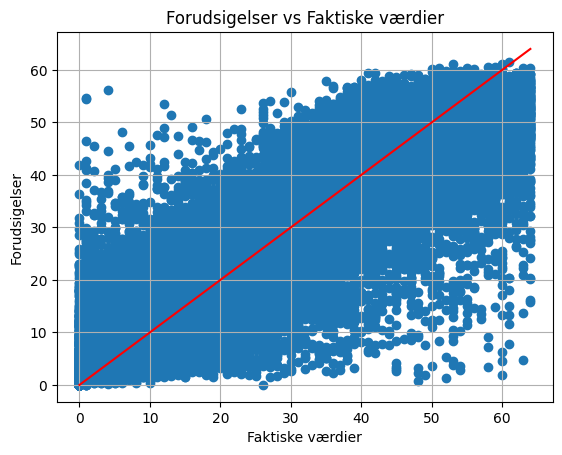

In [ ]:
# Random forest regressor visualiseret
# Plot forudsigelser mod faktiske værdier
plt.scatter(y_test.values, y_pred_rf)
plt.xlabel('Faktiske værdier')
plt.ylabel('Forudsigelser')
plt.title('Forudsigelser vs Faktiske værdier')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')  # Diagonal linje
plt.grid(True)
plt.show()


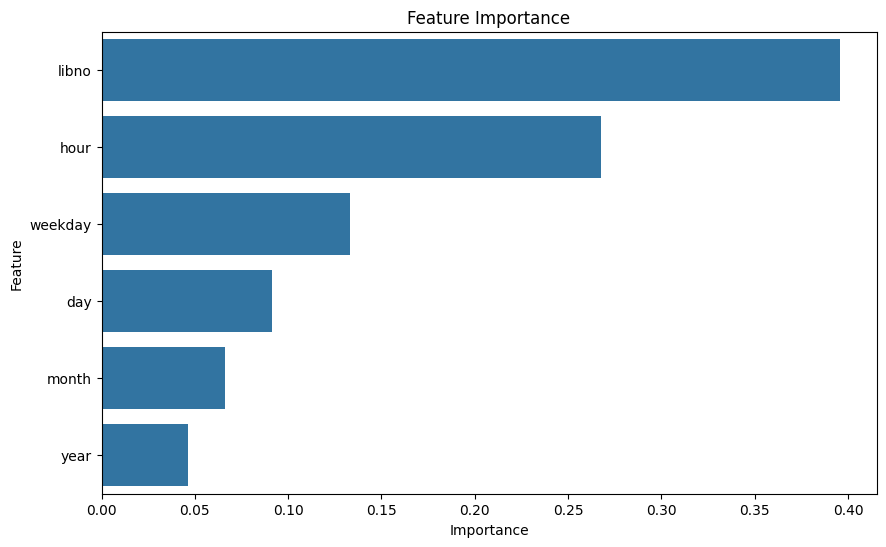

In [ ]:
# Random forest feature importance
importances = rf_regressor.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance')
plt.show()


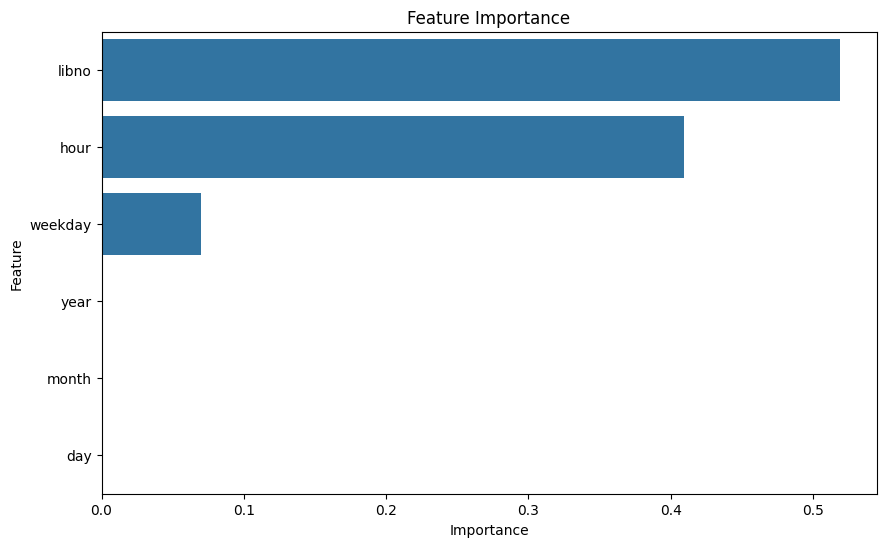

In [ ]:
# Gradient boosting feature importance
importances = gb_regressor.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance')
plt.show()


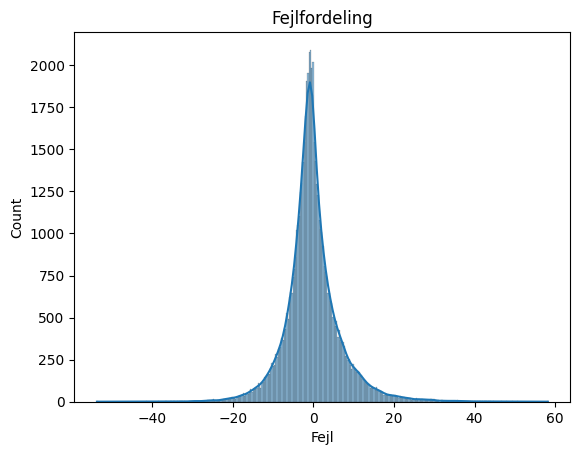

In [ ]:
# Beregn fejl
errors = y_test - y_pred_rf

# Plot fejlfordeling
sns.histplot(errors, kde=True)
plt.xlabel('Fejl')
plt.title('Fejlfordeling')
plt.show()

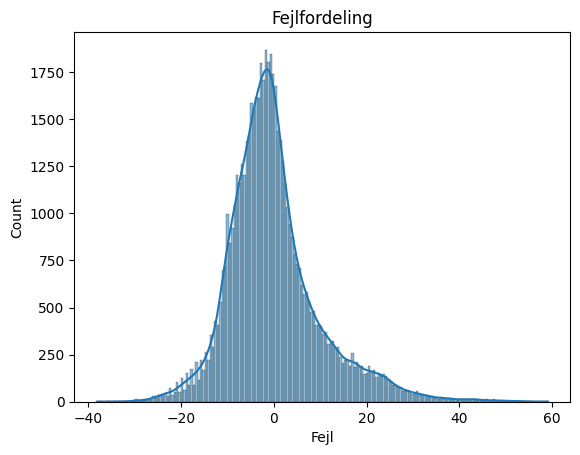

In [ ]:
# Beregn fejl
errors = y_test - y_pred_gb

# Plot fejlfordeling
sns.histplot(errors, kde=True)
plt.xlabel('Fejl')
plt.title('Fejlfordeling')
plt.show()

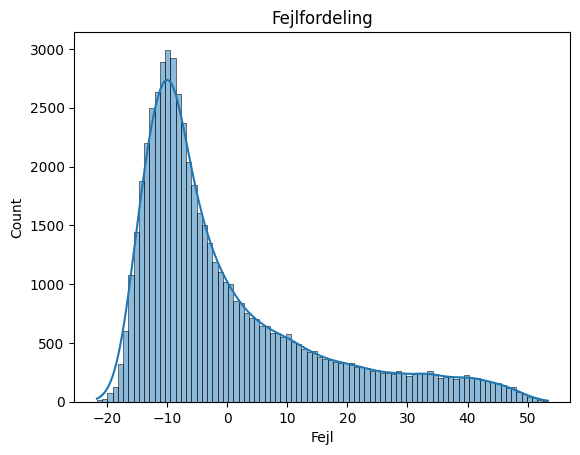

In [ ]:
# Beregn fejl
errors = y_test - y_pred

# Plot fejlfordeling
sns.histplot(errors, kde=True)
plt.xlabel('Fejl')
plt.title('Fejlfordeling')
plt.show()

Predict fremtidige counts pr lib

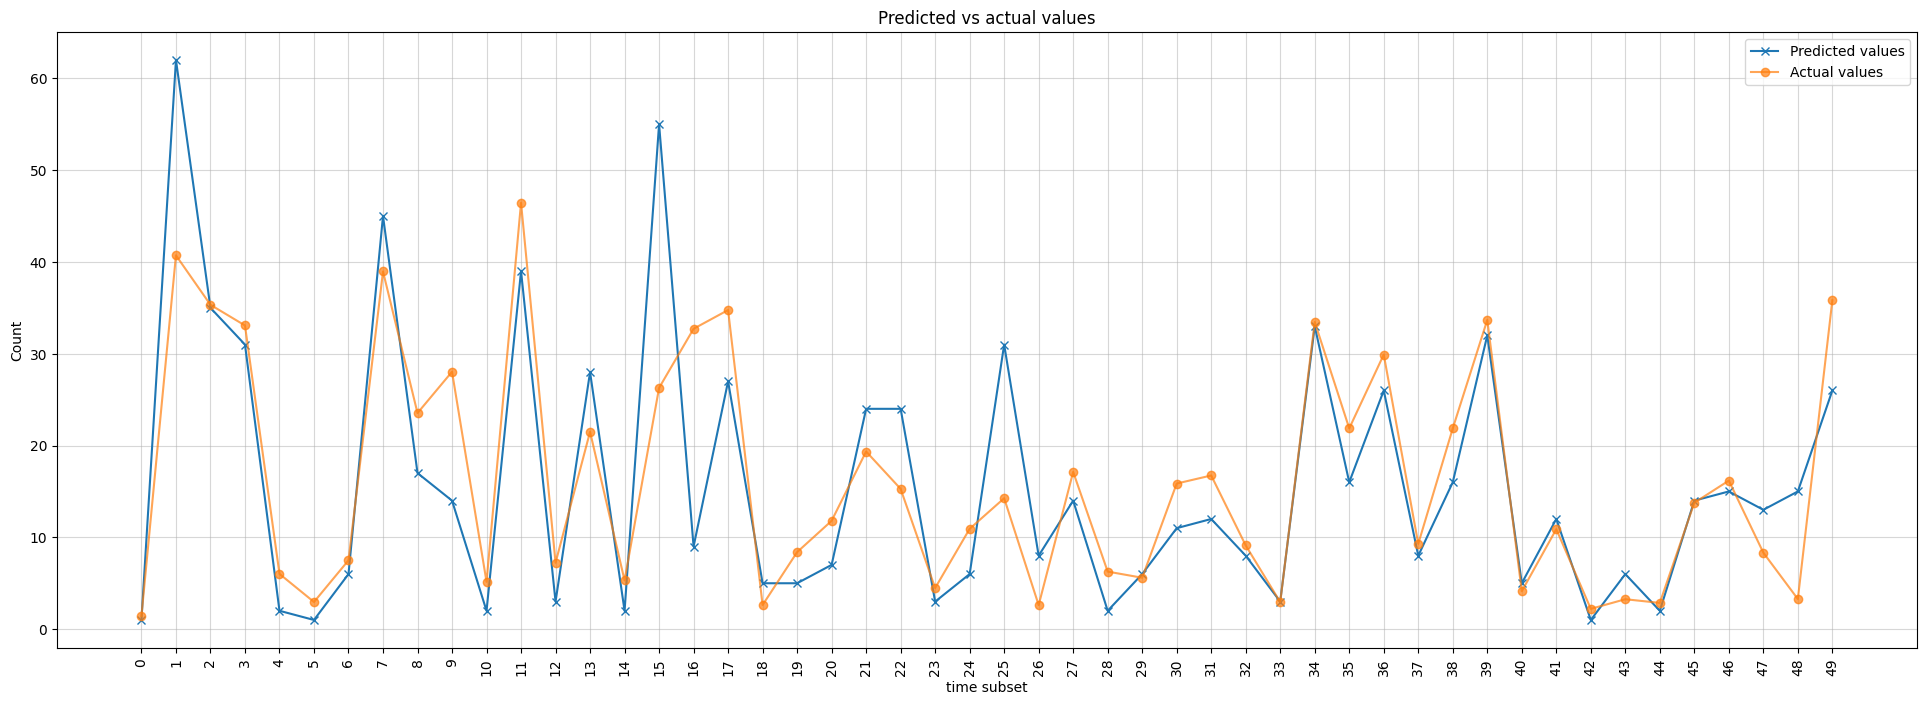

In [ ]:
# Plot forudsigelser mod faktiske værdier
plt.figure(figsize=(24, 8))

plt.plot(y_test.values[:50], marker='x', label='Predicted values')
plt.plot(y_pred_rf[:50], marker='o', label='Actual values', alpha=0.7)

plt.xlabel('time subset')
plt.xticks(range(len(y_test[:50])), rotation=90)
plt.ylabel('Count')

plt.title('Predicted vs actual values')
plt.grid(True, alpha=0.5)
plt.legend()

plt.show()

In [ ]:
# Hypothetical feature values for a day in January 2013
hypothetical_values = {
    'libno': 775144,  # gellerup bibliotek
    'year': 2016,  # jf. transaction data
    'month': 8,  # august
    'weekday': 1,  # tirsdag
    'day': 2,  # 2. august
    'hour': 14,  # kl 14
}

# Reshaping the hypothetical values for prediction
hypothetical_values_array = np.array(list(hypothetical_values.values())).reshape(1, -1)

# Making a prediction using the Linear Regression model
predicted_count = rf_regressor.predict(hypothetical_values_array)

predicted_count[0]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


27.79